# Bayesian Logistic Regression - using bank data

- https://www.srose.biz/wp-content/uploads/2020/08/Bayesian-logistic-regression-with-pymc3.html

<br>

***
***
***

<br>

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from pathlib import Path
import pickle
from collections import OrderedDict
import pandas as pd
import numpy as np
from scipy import stats

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, 
                             precision_recall_curve) 
# import theano
# import pymc3 as pm
# from pymc3.variational.callbacks import CheckParametersConvergence
import statsmodels.formula.api as smf

import arviz as az
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines

from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats

from sklearn.preprocessing import scale

import seaborn as sns
from IPython.display import HTML

In [5]:
sns.set(style="white", color_codes=True)
pd.set_option('display.max_columns', None)

<br>

***

<br>

## Import & View Data

In [6]:
data_path = Path('data')
fig_path = Path('figures')
model_path = Path('models')
for p in [data_path, fig_path, model_path]:
    if not p.exists():
        p.mkdir()

In [7]:
data = pd.read_csv('C:\\Users\\wallj\\DS_Projects\\DataScience\\Datasets\\bank.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [8]:
unique = data.nunique()
unique

age            76
job            12
marital         3
education       4
default         2
balance      3805
housing         2
loan            2
contact         3
day            31
month          12
duration     1428
campaign       36
pdays         472
previous       34
poutcome        4
deposit         2
dtype: int64

In [9]:
mask = data.nunique().values < 31
cat_features = list(unique[mask].index)
cat_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'deposit']

<br>

***

<br>

## EDA

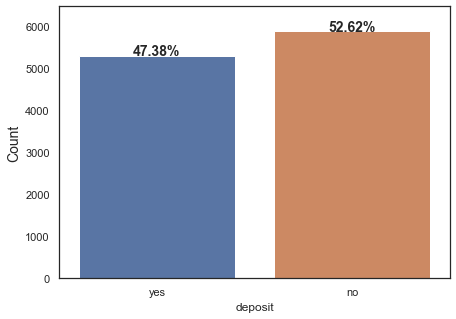

In [10]:
total = len(data)
plt.figure(figsize=(7,5))
g = sns.countplot(x='deposit',data=data)
g.set_ylabel('Count',fontsize=14)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
           height + 1.5,
           '{:1.2f}%'.format(height/total*100),
           ha="center",fontsize=14,fontweight='bold')
plt.margins(y=0.1)
plt.show()

TypeError: Got both 'size' and 'fontsize', which are aliases of one another

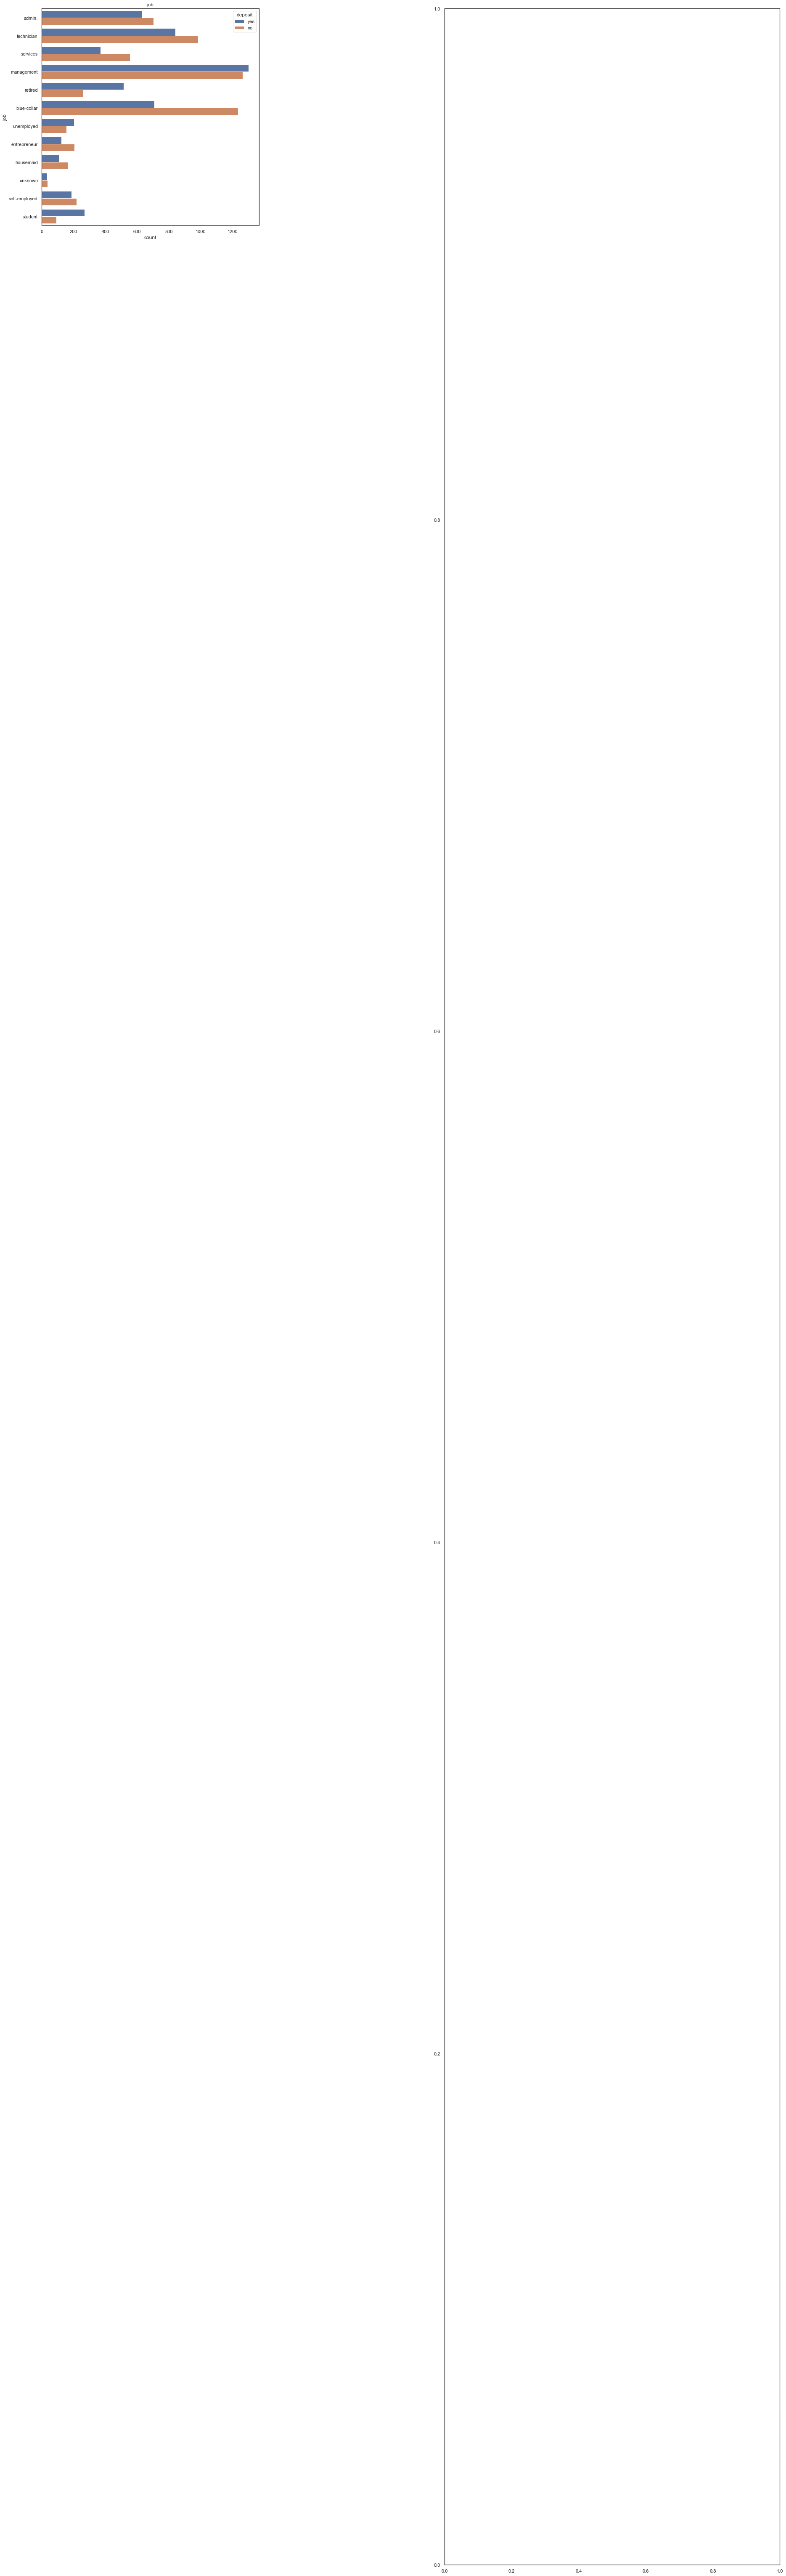

In [11]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(13, 45))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

for i, feature in enumerate(list(data[cat_features]), 1):
    if(feature=='deposit'):
        break
        
    plt.subplot(len(cat_features), 3, i)
    sns.countplot(y=feature, hue='deposit', data=data)
    plt.title(f'{feature}', size=15, fontsize=12)    
    plt.legend(loc='best', prop={'size': 8})
    
plt.tight_layout()       
plt.show()

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='day', hue='deposit', data=data);

In [ ]:
num_features = [f for f in data.columns if f not in cat_features]
num_features.remove('day')
num_features

In [ ]:
basetable0 = pd.DataFrame(index=data.index)
basetable0['deposit'] = data['deposit']
deposit_dict = {'no': 0, 'yes': 1}
basetable0 = basetable0.replace({'deposit': deposit_dict})

for variable in num_features:
    if len(data.groupby(variable)) > 31:
        new_variable = "disc_" + variable
        basetable0[new_variable] = pd.qcut(data[variable], 5, duplicates='drop')

basetable0.head()

In [12]:
def create_pig_table(basetable, target, variable):
    
    groups = basetable[[target,variable]].groupby(variable)
    pig_table = groups[target].agg(Incidence = np.mean, Size = np.size).reset_index()
    
    return pig_table

def plot_pig(pig_table, variable):
    
    plt.figure(figsize=(10, 4))
    plt.ylabel("Size", rotation=0, rotation_mode="anchor", ha="right")
    pig_table["Size"].plot(kind="bar", width=0.5, color="lightgray", edgecolor="none") 
    pig_table["Incidence"].plot(secondary_y=True)
    
    plt.xticks(np.arange(len(pig_table)), pig_table[variable])
    plt.xlim([-0.5, len(pig_table) - 0.5])
    plt.ylabel("Incidence", rotation=0, rotation_mode="anchor", ha="left")
    plt.title(f'{variable}')
    
    plt.show()

In [13]:
variables = list(basetable0.drop('deposit', axis=1).columns)

pig_tables = {}
for variable in variables: 
    pig_table = create_pig_table(basetable0, 'deposit', variable)
    pig_tables[variable] = pig_table

NameError: name 'basetable0' is not defined

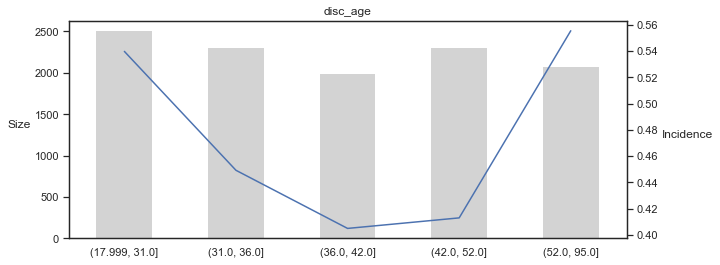

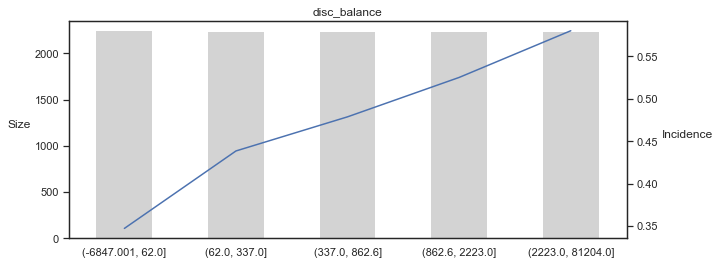

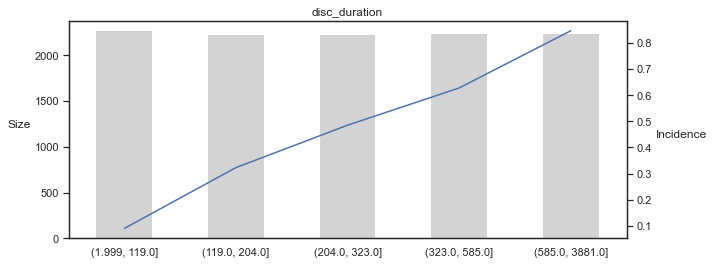

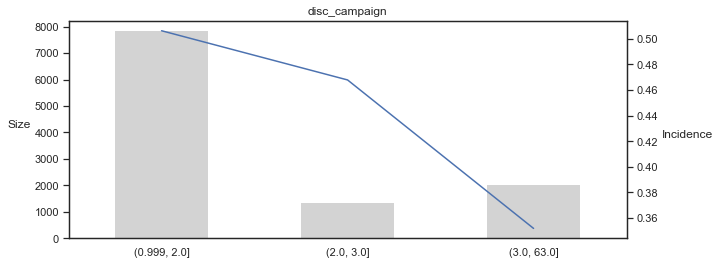

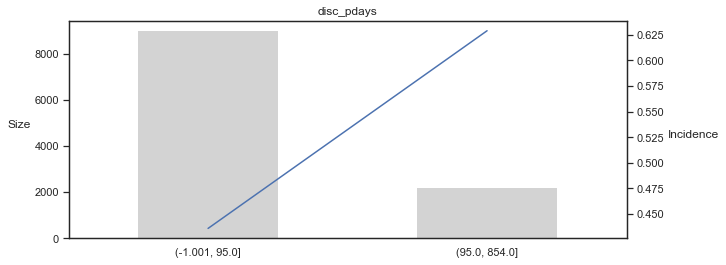

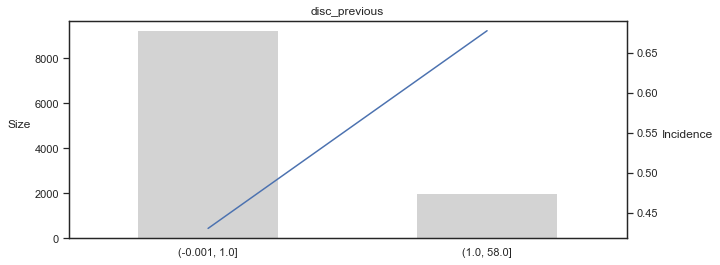

In [15]:
for variable in variables: 
    pig_table = create_pig_table(basetable0, "deposit", variable)
    plot_pig(pig_table, variable)

<br>

***

<br>

## Data Preprocessing

In [14]:
job_dict = {'management': 12, 'admin.': 11, 'entrepreneur': 10, 'technician': 9, 'services': 8, 'self-employed': 7,
            'blue-collar': 6, 'retired': 5, 'housemaid': 4, 'unemployed': 3, 'unknown': 2, 'student': 1}
data = data.replace({'job': job_dict})

marital_dict = {'married': 4, 'single': 3, 'divorced': 2, 'unknown': 1}
data = data.replace({'marital': marital_dict})
data['marital'] = data['marital'].astype(int)

edu_dict = {'tertiary': 4, 'secondary': 3, 'primary': 2, 'unknown': 1}
data = data.replace({'education': edu_dict})

default_dict = {'no': 1, 'yes': 0}
data = data.replace({'default': default_dict})

housing_dict = {'no': 1, 'yes': 0}
data = data.replace({'housing': housing_dict})

loan_dict = {'no': 1, 'yes': 0}
data = data.replace({'loan': loan_dict})

contact_dict = {'cellular': 3, 'telephone': 2, 'unknown': 1}
data = data.replace({'contact': contact_dict})

poutcome_dict = {'success': 4, 'other': 3, 'unknown': 2, 'failure': 1}
data = data.replace({'poutcome': poutcome_dict})

month_dict = {'jan': 1, 'feb': 2, 'aug': 8, 'nov': 11, 'jun': 6, 'apr': 4, 'jul': 7, 'may': 5, 'oct': 10, 
              'mar': 3, 'sep': 9, 'dec': 12}
data = data.replace({'month': month_dict})

pdays_dict = {-1: 0}
data = data.replace({'pdays': pdays_dict})

data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,11,4,3,1,2343,0,1,1,5,5,1042,1,0,0,2,yes
1,56,11,4,3,1,45,1,1,1,5,5,1467,1,0,0,2,yes
2,41,9,4,3,1,1270,0,1,1,5,5,1389,1,0,0,2,yes
3,55,8,4,3,1,2476,0,1,1,5,5,579,1,0,0,2,yes
4,54,11,4,4,1,184,1,1,1,5,5,673,2,0,0,2,yes


In [15]:
data.dtypes

age           int64
job           int64
marital       int32
education     int64
default       int64
balance       int64
housing       int64
loan          int64
contact       int64
day           int64
month         int64
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome      int64
deposit      object
dtype: object

In [16]:
mask = data.nunique().values > 31
num_features = list(unique[mask].index)
num_features

['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

<br>

***

<br>

## Distributions & Transformations

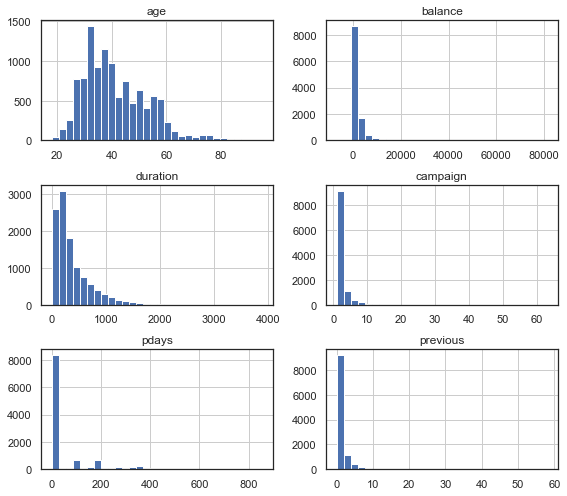

In [17]:
data[num_features].hist(bins=30, figsize=(8,7))
plt.tight_layout();

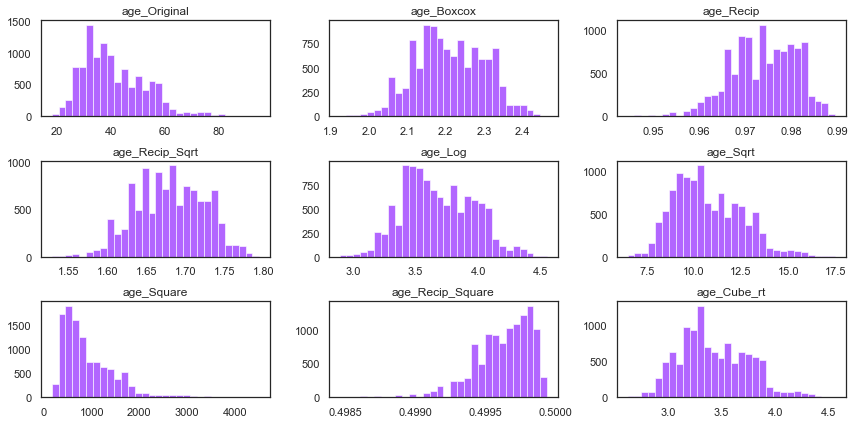

BC MinMax Scaled


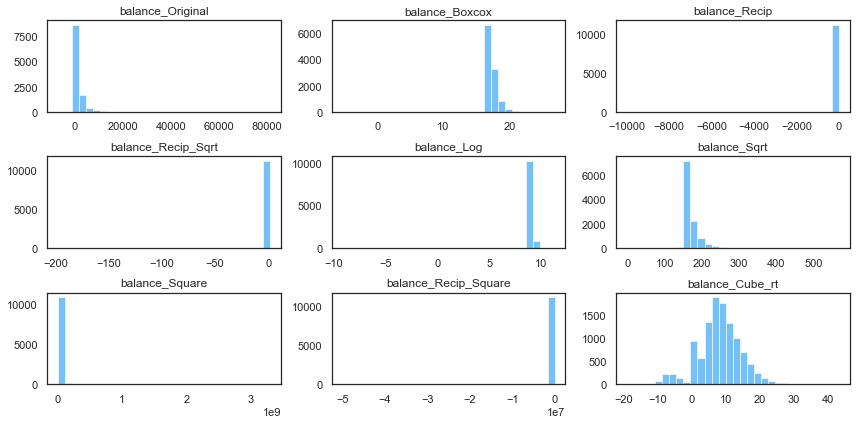

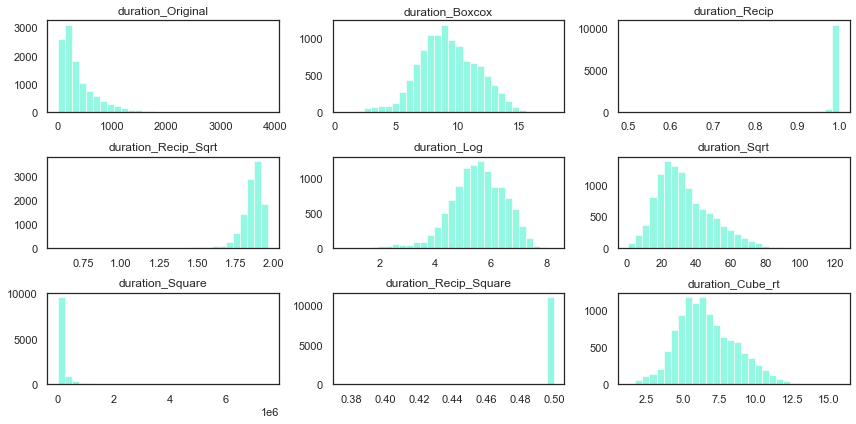

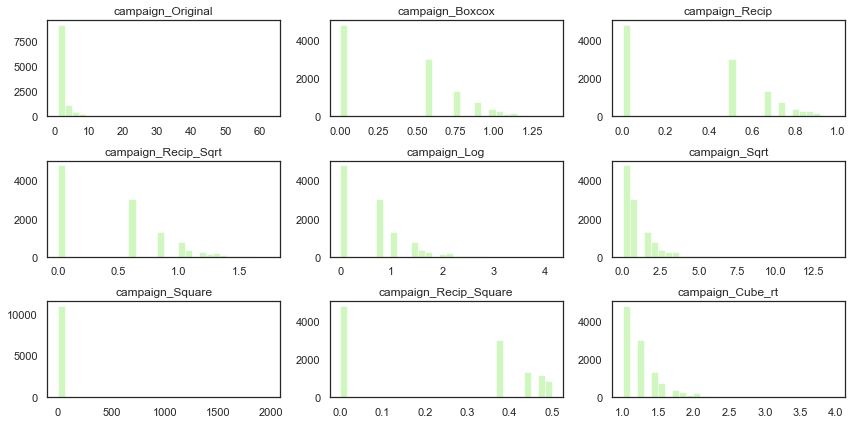

BC MinMax Scaled


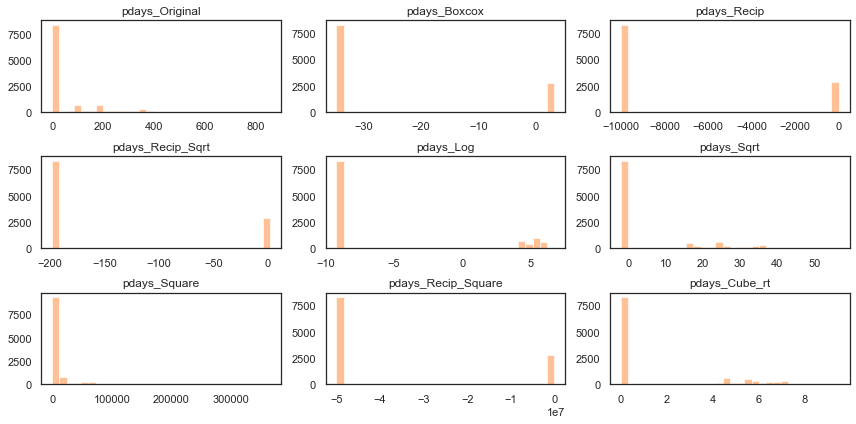

BC MinMax Scaled


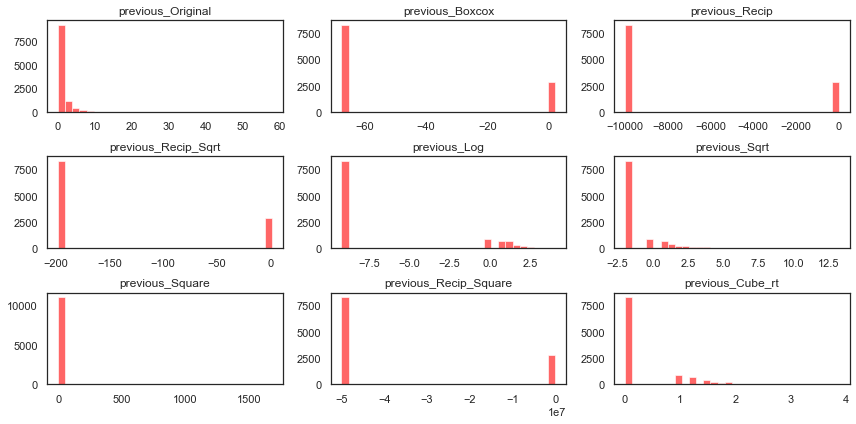

In [18]:
colors = cm.rainbow(np.linspace(0, 1, len(num_features)))

for col, c in zip(num_features,colors):
    minmax = MinMaxScaler(feature_range=(0.0001, max(data[col].values)))
    if data[col].describe().iloc[3] <= 0.0:
        z = minmax.fit_transform(data[col].values.reshape(-1,1))
        z = np.squeeze(z)
        print('BC MinMax Scaled')
    else:
        z = data[col]
        
    z0, _ = stats.boxcox(z, lmbda=None)
    z1 = stats.boxcox(z, lmbda=-1)
    z2 = stats.boxcox(z, lmbda=-0.5)
    z3 = stats.boxcox(z, lmbda=0.0)
    z4 = stats.boxcox(z, lmbda=0.5)
    z5 = stats.boxcox(z, lmbda=2)
    z6 = stats.boxcox(z, lmbda=-2)
    z7 = np.cbrt(data[col])

    trans = [data[col], z0, z1, z2, z3, z4, z5, z6, z7]
    names = ['Original', 'Boxcox', 'Recip', 'Recip_Sqrt', 'Log', 'Sqrt', 'Square', 'Recip_Square', 'Cube_rt']

    fig = plt.figure(figsize=(12,6))
    for i, t, n in zip(range(1, 10), trans, names):
        ax = fig.add_subplot(3, 3, i)
        plt.hist(t, bins=30, color=c, alpha=0.6)
        plt.title(col+'_'+n)
        
    plt.tight_layout()
    plt.show();

In [19]:
data.balance = np.cbrt(data.balance)

age,_ = stats.boxcox(data.age,lmbda=None)
data.age = age

duration,_ = stats.boxcox(data.duration, lmbda=None)
data.duration = duration

In [20]:
cols = ['duration', 'balance', 'age']

data.loc[:, cols] = scale(data.loc[:, cols])

In [21]:
nums = data[num_features]
nums['deposit'] = data.deposit

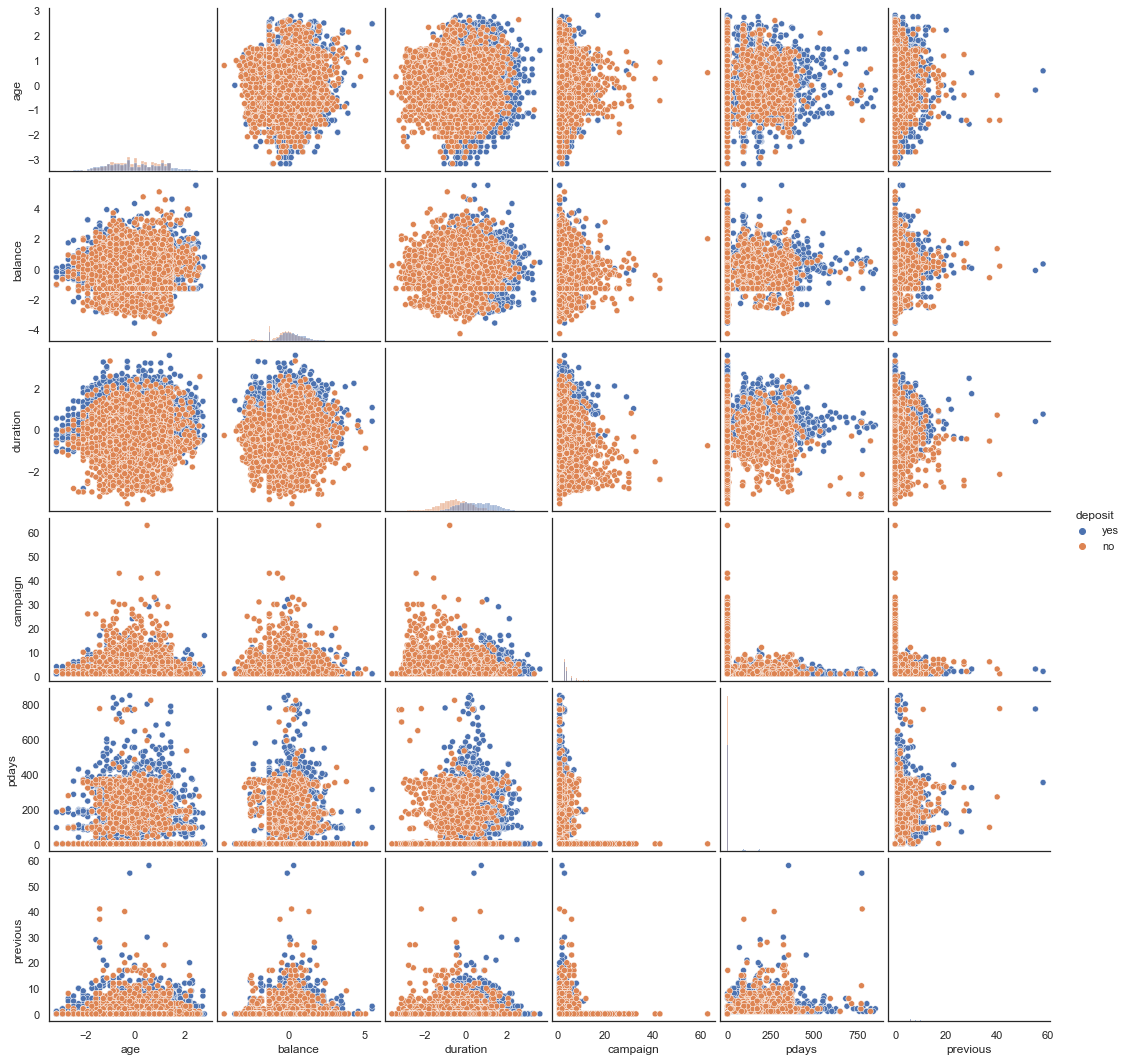

In [22]:
sns.pairplot(nums, hue='deposit', diag_kind='hist');

In [23]:
deposit_dict = {'no': 0, 'yes': 1}
data = data.replace({'deposit': deposit_dict})

data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,1.393156,11,4,3,1,0.800181,0,1,1,5,5,1.633998,1,0,0,2,1
1,1.225089,11,4,3,1,-0.723010,1,1,1,5,5,2.107157,1,0,0,2,1
2,0.163473,9,4,3,1,0.416053,0,1,1,5,5,2.029763,1,0,0,2,1
3,1.166438,8,4,3,1,0.838821,0,1,1,5,5,0.881662,1,0,0,2,1
4,1.106378,11,4,4,1,-0.389262,1,1,1,5,5,1.067320,2,0,0,2,1


<br>

***

<br>

## Correlations

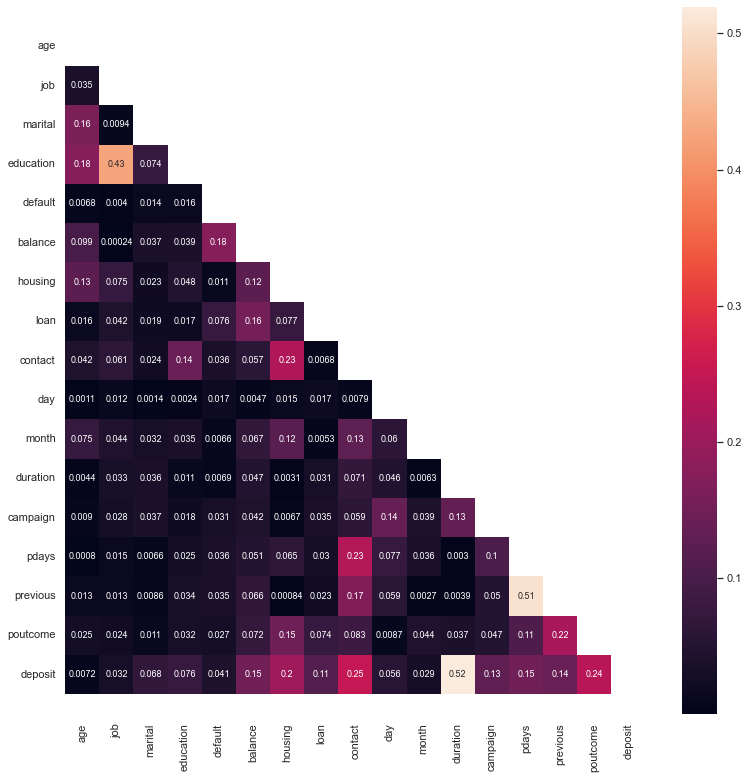

In [24]:
plt.figure(figsize=(13, 13))
corr = data.corr() 
mask = np.tri(*corr.shape).T 
sns.heatmap(corr.abs(), mask=mask, annot=True, annot_kws={"size": 9})
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.show()

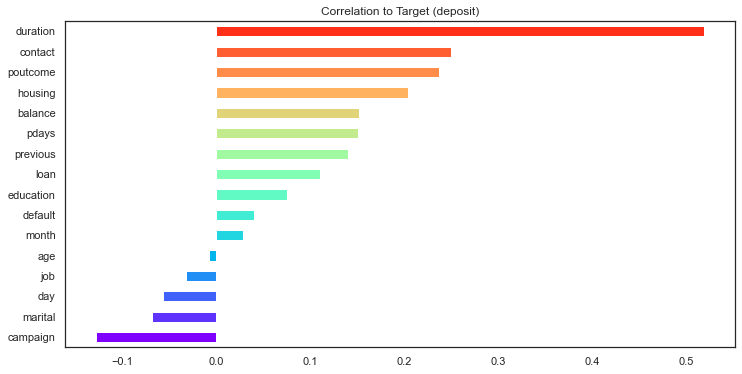


 duration     0.519315
contact      0.249847
poutcome     0.237089
housing      0.203888
balance      0.151666
pdays        0.151167
previous     0.139867
loan         0.110580
education    0.075583
default      0.040680
month        0.028645
age         -0.007167
job         -0.031694
day         -0.056326
marital     -0.068325
campaign    -0.128081
dtype: float64


In [25]:
n_fts = len(data.columns)
colors = cm.rainbow(np.linspace(0, 1, n_fts))

data.drop('deposit',axis=1).corrwith(data.deposit).sort_values(ascending=True).plot(kind='barh', 
                                                                                     color=colors, figsize=(12, 6))
plt.title('Correlation to Target (deposit)')
plt.show()

print('\n',data.drop('deposit',axis=1).corrwith(data.deposit).sort_values(ascending=False))

<br>

***

<br>

## Logistic Regression w/one variable

In [26]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,1.393156,11,4,3,1,0.800181,0,1,1,5,5,1.633998,1,0,0,2,1
1,1.225089,11,4,3,1,-0.723010,1,1,1,5,5,2.107157,1,0,0,2,1
2,0.163473,9,4,3,1,0.416053,0,1,1,5,5,2.029763,1,0,0,2,1
3,1.166438,8,4,3,1,0.838821,0,1,1,5,5,0.881662,1,0,0,2,1
4,1.106378,11,4,4,1,-0.389262,1,1,1,5,5,1.067320,2,0,0,2,1


In [27]:
y_simple = data['deposit']
x_n = 'duration'
x_c = data[x_n].values

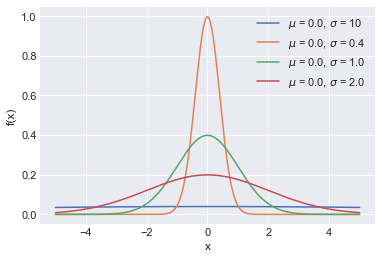

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
plt.style.use('seaborn-darkgrid')
x = np.linspace(-5, 5, 1000)
mus = [0., 0., 0., 0.]
sigmas = [10, 0.4, 1., 2.]
for mu, sigma in zip(mus, sigmas):
    pdf = st.norm.pdf(x, mu, sigma)
    plt.plot(x, pdf, label=r'$\mu$ = {}, $\sigma$ = {}'.format(mu, sigma))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

In [29]:
with pm.Model() as model_simple:
    # random variables for the coefficient with
    # uniformative priors for each parameter
    a = pm.Normal('a',mu=0,sd=10)
    b = pm.Normal('b',mu=0,sd=10)
    
    # Transform rando variables into vector of probabilities
    u = a + pm.math.dot(x_c,b)
    o = pm.Deterministic('o',pm.math.sigmoid(u))
    
    # The decision boundary
    db = pm.Deterministic('db',-a/b)
    
    # Bernoulli random vector with probability of success
    # given sigmoid function and actual data as observed
    y = pm.Bernoulli(name='logit',p=o,observed=y_simple)
    
    trace_simple = pm.sample(1000,tune=1000,chains=4,init='adapt_diag',cores=5)

NameError: name 'pm' is not defined

In [ ]:
model_simple.model

In [ ]:
# pm.model_to_graphviz(model_simple)

In [ ]:
theta = trace_simple['o'].mean(axis=0)
idx = np.argsort(x_c)

plt.plot(x_c[idx],theta[idx])